# Exploratory Data Analysis - US Corn Yield Prediction

This notebook performs a comprehensive analysis of corn yield and weather conditions data in the United States.

**Main objective:** Build a model to predict US national corn yield in 2024 (bu/acre)

## 1. Configuration et Import des Bibliothèques

In [3]:
# Standard library imports
from pathlib import Path
import warnings

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Modeling libraries
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import pwlf  # Piecewise Linear Fit

# Suppress warnings
warnings.filterwarnings('ignore')

# Plot configuration
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Data Path Configuration

In [4]:
# Define data paths
BASE_PATH = Path.cwd().parent
RAW_DATA_PATH = BASE_PATH / "data" / "raw"
PROCESSED_DATA_PATH = BASE_PATH / "data" / "processed"
MODEL_PATH = BASE_PATH / "models"

## 3. Data Loading

### Data sources:
- **USDA Yields**: Historical corn yield data (national, state, county)
- **Weather data**: Temperature and soil moisture (2020-2024)
- **Source**: https://quickstats.nass.usda.gov

In [5]:
# Loading data into a structured dictionary
datasets = {
    'yield_national': pd.read_csv(RAW_DATA_PATH / "USDA_corn_yield_national_bu_acre.csv"),
    'yield_state': pd.read_csv(RAW_DATA_PATH / "USDA_corn_yield_state_bu_acre.csv"),
    'yield_county': pd.read_csv(RAW_DATA_PATH / "USDA_corn_yield_county_bu_acre.csv"),
    'weather': pd.read_parquet(RAW_DATA_PATH / "hist_wx_df.parquet")
}
print("Data loaded successfully:")

for dataset_name, df in datasets.items():
    print(f"- {dataset_name}: {df.shape[0]:,} lignes, {df.shape[1]} colonnes")

Data loaded successfully:
- yield_national: 361 lignes, 21 colonnes
- yield_state: 13,469 lignes, 21 colonnes
- yield_county: 44,673 lignes, 21 colonnes
- weather: 8,527,402 lignes, 9 colonnes


In [6]:
# Drop columns with >30% missing values or only one unique value
threshold = 0.3

for name, df in datasets.items():
    # Rename target column
    df.rename(columns={'Value': 'yield_bu_acre', 'year': 'Year'}, inplace=True)

    # Identify columns to drop
    too_many_nans = df.columns[df.isnull().mean() > threshold]
    constant_cols = df.columns[df.nunique(dropna=False) <= 1]
    cols_to_drop = set(too_many_nans).union(constant_cols)

    # Drop columns
    datasets[name] = df.drop(columns=cols_to_drop)

    print(f"{name}: dropped {len(cols_to_drop)} column(s) — {list(cols_to_drop)}")

yield_national: dropped 18 column(s) — ['Ag District Code', 'County ANSI', 'Program', 'Watershed', 'Zip Code', 'Region', 'State', 'Commodity', 'CV (%)', 'Week Ending', 'Geo Level', 'watershed_code', 'County', 'Domain Category', 'Data Item', 'State ANSI', 'Ag District', 'Domain']
yield_state: dropped 16 column(s) — ['County ANSI', 'Program', 'Watershed', 'Zip Code', 'Region', 'Commodity', 'CV (%)', 'Week Ending', 'Geo Level', 'watershed_code', 'County', 'Domain Category', 'Data Item', 'Ag District', 'Ag District Code', 'Domain']
yield_county: dropped 13 column(s) — ['Period', 'Commodity', 'CV (%)', 'Geo Level', 'Domain Category', 'Data Item', 'Domain', 'Program', 'Watershed', 'Zip Code', 'Region', 'watershed_code', 'Week Ending']
weather: dropped 0 column(s) — []


## 4. Initial Exploratory Analysis

In [7]:
# Analysis of geographic coverage
num_states_weather = datasets['weather']['adm1_name'].nunique()
num_states_yield_state = datasets['yield_state']['State'].nunique()
num_states_yield_county = datasets['yield_county']['State'].nunique()

print(f"Couverture géographique :")
print(f"- États dans les données météo: {num_states_weather}")
print(f"- États dans yield_state: {num_states_yield_state}")
print(f"- États dans yield_county: {num_states_yield_county}")
print(f"\n⚠️  Observation: Les données météo ne couvrent que {num_states_weather} états sur {num_states_yield_state} disponibles")
print(f"   Période météo: 2020-2024 pour {num_states_weather} états")

Couverture géographique :
- États dans les données météo: 13
- États dans yield_state: 49
- États dans yield_county: 41

⚠️  Observation: Les données météo ne couvrent que 13 états sur 49 disponibles
   Période météo: 2020-2024 pour 13 états


## 5. Historical Yield Trends Visualization

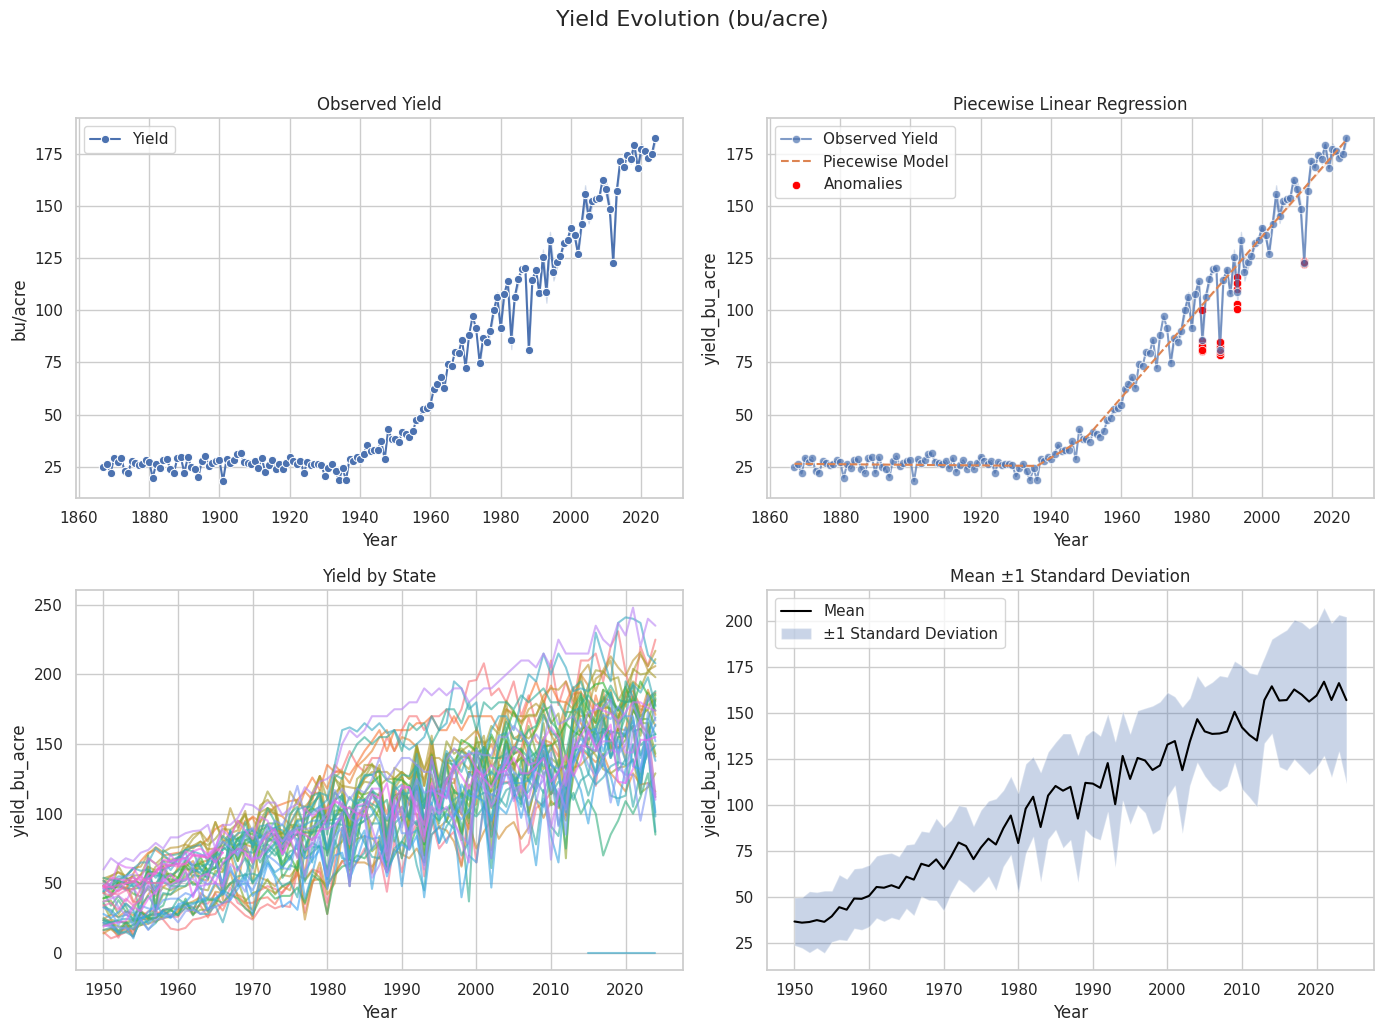

Years with significantly low yield:
[1983, 1983, 1983, 1988, 1988, 1988, 1988, 1988, 1993, 1993, 2012, 2012, 2012, 2012, 2012]


In [8]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Yield Evolution (bu/acre)", fontsize=16, y=1.03)

# 1. Simple evolution
df_nat = datasets['yield_national'].set_index('Year').sort_index()
sns.lineplot(ax=axs[0,0], x=df_nat.index, y='yield_bu_acre', data=df_nat, marker='o', label='Yield')
axs[0,0].set(xlabel='Year', ylabel='bu/acre', title='Observed Yield')
axs[0,0].legend()

# 2. Piecewise linear regression
x, y = df_nat.index.values.astype(float), df_nat['yield_bu_acre']
model = pwlf.PiecewiseLinFit(x, y)
model.fit(3)
y_hat = model.predict(x)
resid = y - y_hat
low_years = df_nat.index[resid < resid.mean() - 2 * resid.std()]

sns.lineplot(ax=axs[0,1], x=x, y=y, marker='o', label='Observed Yield', alpha=0.7)
sns.lineplot(ax=axs[0,1], x=x, y=y_hat, linestyle='--', label='Piecewise Model')
sns.scatterplot(ax=axs[0,1], x=df_nat.loc[low_years].index, y=df_nat.loc[low_years, 'yield_bu_acre'], color='red', label='Anomalies')
axs[0,1].set_title('Piecewise Linear Regression')
axs[0,1].legend()

# 3. Yield evolution by state
df_state = datasets['yield_state']
df_state = df_state[(df_state['Year'] >= 1950) & (df_state.Period == 'YEAR')]
sns.lineplot(ax=axs[1,0], data=df_state, x='Year', y='yield_bu_acre', hue='State', legend=False, alpha=0.6)
axs[1,0].set_title("Yield by State")

# 4. Mean ±1 standard deviation
mean = df_state.groupby('Year')['yield_bu_acre'].mean()
std = df_state.groupby('Year')['yield_bu_acre'].std()
sns.lineplot(ax=axs[1,1], x=mean.index, y=mean, color='black', label='Mean')
axs[1,1].fill_between(mean.index, mean - std, mean + std, alpha=0.3, label='±1 Standard Deviation')
axs[1,1].set_title("Mean ±1 Standard Deviation")
axs[1,1].legend()

plt.tight_layout()
plt.show()

print("Years with significantly low yield:")
print(low_years.tolist())

One possible idea would have been to model each state's yield individually. However, since we don't have the cultivated area per year and state in our dataset, we cannot pursue this idea.

## 7. Data Description

### Yield data structure:
- **yield_national**: National average yield in bushels per acre
- **yield_state**: Yield by state and year, with monthly forecasts
- **yield_county**: Yield by county and year

### Weather data structure:
- **Period**: 2020-2024, daily data
- **Variables**:
  - `tmin`, `tmax`: Minimum and maximum temperatures (°C)
  - `swvl1`, `swvl2`: Volumetric soil water content (m³/m³)
  - `adm1_name`: State name
  - `adm2_name`: County name

## 8. Definition of Agronomic Stress Thresholds

### Temperature stress:
- **Heat stress**: `tmax > 35°C` during flowering → yield loss due to poor pollination
- **Cold stress**: `tmin < 10°C` during emergence → risk of stress and slow development


### Water stress:
- **Water stress**: `swvl1` or `swvl2 < 0.2 m³/m³` → possible water stress
- **Optimal conditions**: `swvl > 0.35 m³/m³` → good moisture conditions

## 9. Definition of Corn Growth Stages

### Critical stages and stress sensitivity:

| Stage | Period | Sensitivity | Description |
|-------|---------|-------------|-------------|
| **Emergence to V6** | April - May | Low to moderate | Cold stress can slow development |
| **V6 to V12** | May - June | Moderate | Water stress can delay development |
| **VT (Tasseling)** | Late June - Early July | **Very critical** | Temperature/water stress affects pollination |
| **R1 (Silking)** | July | **Most critical** | Stress can cause kernel abortion |
| **R2-R4 (Grain filling)** | August | Moderate to high | Water stress → smaller kernels |
| **R6 (Maturity)** | September | Low | Plant less sensitive to stress |

In [9]:
datasets.keys()

dict_keys(['yield_national', 'yield_state', 'yield_county', 'weather'])

In [10]:
# Prepare weather data for stage analysis
weather_df = datasets['weather'].copy()

# Convert and extract temporal information
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df['Year'] = weather_df['date'].dt.year
weather_df['month'] = weather_df['date'].dt.month
weather_df['day_of_year'] = weather_df['date'].dt.dayofyear

print(f"📅 Weather data prepared: {weather_df.shape[0]:,} records")
print(f"   Period: {weather_df['Year'].min()} - {weather_df['Year'].max()}")
print(f"   States covered: {weather_df['adm1_name'].nunique()}")


📅 Weather data prepared: 8,527,402 records
   Period: 2000 - 2024
   States covered: 13


In [11]:
# Define growth stages (days after planting)
GROWTH_STAGES = {
    'emergence': (0, 14),
    'vegetative': (15, 40),
    'tasseling': (60, 70),
    'silking': (70, 85),
    'grain_filling': (86, 110),
    'maturity': (111, 130)
}

# Set planting date (April 20 = day 110)
PLANTING_DATE = pd.to_datetime('2025-04-20')
PLANTING_DAY_OF_YEAR = 110

# Calculate days after planting
weather_df['days_after_planting'] = weather_df['day_of_year'] - PLANTING_DAY_OF_YEAR

def assign_growth_stage(days_after_planting):
    """Assign a growth stage based on days after planting."""
    for stage_name, (start_day, end_day) in GROWTH_STAGES.items():
        if start_day <= days_after_planting <= end_day:
            return stage_name
    return None

# Apply stage assignment
weather_df['growth_stage'] = weather_df['days_after_planting'].apply(assign_growth_stage)

# Filter to keep only relevant growth stage records
weather_df_filtered = weather_df.dropna(subset=['growth_stage'])

print(f"🌱 Growth stages assigned:")
stage_counts = weather_df_filtered['growth_stage'].value_counts().sort_index()
for stage, count in stage_counts.items():
    print(f"   - {stage}: {count:,} records")

print(f"\n📊 Filtered data: {weather_df_filtered.shape[0]:,} records retained")


🌱 Growth stages assigned:
   - emergence: 356,955 records
   - grain_filling: 575,725 records
   - maturity: 460,580 records
   - silking: 345,435 records
   - tasseling: 253,299 records
   - vegetative: 598,754 records

📊 Filtered data: 2,590,748 records retained


## 10. Stress Indicator Calculation

In [12]:
# Define stress thresholds
STRESS_THRESHOLDS = {
    'cold_temp': 10,       # °C - cold stress threshold
    'heat_temp': 35,       # °C - heat stress threshold
    'low_moisture': 0.2,   # m³/m³ - low soil moisture threshold
    'drought_tolerance': 5 # days of drought tolerance
}

# Compute daily stress indicators
weather_df_filtered['stress_cold_emergence'] = (
    (weather_df_filtered['growth_stage'] == 'emergence') & 
    (weather_df_filtered['tmin'] < STRESS_THRESHOLDS['cold_temp'])
).astype(int)

weather_df_filtered['stress_heat_tasseling'] = (
    (weather_df_filtered['growth_stage'] == 'tasseling') & 
    (weather_df_filtered['tmax'] > STRESS_THRESHOLDS['heat_temp'])
).astype(int)

weather_df_filtered['stress_heat_silking'] = (
    (weather_df_filtered['growth_stage'] == 'silking') & 
    (weather_df_filtered['tmax'] > STRESS_THRESHOLDS['heat_temp'])
).astype(int)

weather_df_filtered['stress_low_soil_moisture'] = (
    (weather_df_filtered['swvl1'] < STRESS_THRESHOLDS['low_moisture']) | 
    (weather_df_filtered['swvl2'] < STRESS_THRESHOLDS['low_moisture'])
).astype(int)

print(f"✅ Stress indicators computed using thresholds:")
for threshold_name, value in STRESS_THRESHOLDS.items():
    print(f"   - {threshold_name}: {value}")

✅ Stress indicators computed using thresholds:
   - cold_temp: 10
   - heat_temp: 35
   - low_moisture: 0.2
   - drought_tolerance: 5


## 11. State-Level Stress Data Aggregation

In [13]:
# Aggregate stress indicators by state and year
stress_aggregation_columns = [
    'stress_cold_emergence',
    'stress_heat_tasseling', 
    'stress_heat_silking',
    'stress_low_soil_moisture'
]

stress_state_summary = weather_df_filtered.groupby(['adm1_name', 'Year']).agg({
    col: 'sum' for col in stress_aggregation_columns
}).reset_index()

# Create binary risk indicators
stress_state_summary['risk_cold'] = stress_state_summary['stress_cold_emergence'] > 0
stress_state_summary['risk_heat'] = (
    stress_state_summary['stress_heat_tasseling'] + 
    stress_state_summary['stress_heat_silking']
) > 0
stress_state_summary['risk_drought'] = (
    stress_state_summary['stress_low_soil_moisture'] > STRESS_THRESHOLDS['drought_tolerance']
)

# Convert booleans to integers
risk_columns = ['risk_cold', 'risk_heat', 'risk_drought']
stress_state_summary[risk_columns] = stress_state_summary[risk_columns].astype(int)


## 12. County-Level Stress Data Aggregation

In [14]:
# Aggregate stress indicators by county and year
stress_county_summary = weather_df_filtered.groupby(['adm2_name', 'Year']).agg({
    col: 'sum' for col in stress_aggregation_columns
}).reset_index()

# Create binary risk indicators for counties
stress_county_summary['risk_cold'] = stress_county_summary['stress_cold_emergence'] > 0
stress_county_summary['risk_heat'] = (
    stress_county_summary['stress_heat_tasseling'] + 
    stress_county_summary['stress_heat_silking']
) > 0
stress_county_summary['risk_drought'] = (
    stress_county_summary['stress_low_soil_moisture'] > STRESS_THRESHOLDS['drought_tolerance']
)

print(f"📊 Stress data aggregated by county:")
print(f"   - {stress_county_summary.shape[0]} county-year records")
print(f"   - {stress_county_summary['adm2_name'].nunique()} unique counties")
print(f"   - Period: {stress_county_summary['Year'].min()}–{stress_county_summary['Year'].max()}")


📊 Stress data aggregated by county:
   - 15175 county-year records
   - 607 unique counties
   - Period: 2000–2024


## 13. Annual Data for Modeling

In [15]:
# Prepare national yields
yield_national_df = datasets['yield_national'].copy()
yield_national_df = yield_national_df[yield_national_df.Period=='YEAR'].set_index('Year')\
    .rename(columns={'yield_bu_acre': 'NATIONAL_yield'}).drop(columns=['Period'])
    
# Compile weather data by year for each state
value_cols = [
    'stress_cold_emergence',
    'stress_heat_tasseling',
    'stress_heat_silking',
    'stress_low_soil_moisture',
    'risk_cold',
    'risk_heat',
    'risk_drought'
]

# Create multi-index on State and year
stress_state_summary['State'] = stress_state_summary['adm1_name'].str.upper()
df_stacked = stress_state_summary.set_index(['State', 'Year'])[value_cols].stack().reset_index()

df_stacked['col'] = df_stacked['State'] +'_' + df_stacked['level_2']
df_year_state_stress = df_stacked.pivot(index='Year', columns='col', values=0)

# Yield by year by state
yield_state_df = datasets['yield_state'].loc[datasets['yield_state'].Period=='YEAR',\
    ['Year', 'Period', 'State', 'yield_bu_acre']].copy()
df_year_state_yield = yield_state_df.pivot(index='Year', columns='State', values='yield_bu_acre').add_suffix('_yield')

# Aggregation of the data per year
df_year = yield_national_df\
    .merge(df_year_state_yield, how='left', left_index=True, right_index=True)\
    .merge(df_year_state_stress, how='left', left_index=True, right_index=True)

# Focus on modern era (1980+) for better relevance
# We sort the year as ascending for imputing, we remove the columns with only nan
df_modern = df_year[df_year.index >= 1980].dropna(axis=1, how='all').sort_index(ascending=True).copy()

### Export intermediate results

In [16]:
df_year.to_csv(PROCESSED_DATA_PATH / "df_year.csv")
df_modern.to_csv(PROCESSED_DATA_PATH / "df_modern.csv")
yield_national_df.to_csv(PROCESSED_DATA_PATH / "yield_national_df.csv")
stress_county_summary.to_csv(PROCESSED_DATA_PATH / "stress_county_summary.csv")
stress_state_summary.to_csv(PROCESSED_DATA_PATH / "stress_state_summary.csv")
weather_df_filtered.to_csv(PROCESSED_DATA_PATH / "weather_df_filtered.csv")

## 14. Modélisation - Feature

In [17]:
# Feature selection
# Key producing states
key_states = ['ILLINOIS', 'IOWA', 'NEBRASKA', 'MINNESOTA', 'INDIANA', 'KANSAS', 'OHIO', 'SOUTH DAKOTA', 'WISCONSIN', 'MISSOURI']

# Features: state yields + weather-related variables
yield_features = [f"{state}_yield" for state in key_states if f"{state}_yield" in df_modern.columns]
weather_features = [col for col in df_modern.columns if any(state in col for state in key_states) and ('stress' in col or 'risk' in col)]

print(f"Yield features: {len(yield_features)}")
print(f"Weather features: {len(weather_features)}")
print(f"Weather feature examples: {weather_features[:5]}")

Yield features: 10
Weather features: 70
Weather feature examples: ['ILLINOIS_risk_cold', 'ILLINOIS_risk_drought', 'ILLINOIS_risk_heat', 'ILLINOIS_stress_cold_emergence', 'ILLINOIS_stress_heat_silking']


In [18]:
# Create lag features
def create_lag_features(df, features, lags=[1, 2]):
    """Create lagged features"""
    df_lagged = df.copy()
    
    for feature in features:
        if feature in df.columns:
            for lag in lags:
                df_lagged[f"{feature}_lag{lag}"] = df[feature].shift(lag)
    
    return df_lagged.reset_index()

# Important features to lag
important_features = yield_features[:5] + [col for col in weather_features if 'drought' in col or 'heat' in col][:10]

# Apply lag creation
df_with_lags = create_lag_features(df_modern, important_features, lags=[1, 2])

print(f"Features after lags: {df_with_lags.shape[1]}")
lag_features = [col for col in df_with_lags.columns if 'lag' in col]
print(f"New lag features: {len(lag_features)}")
print(f"Examples: {lag_features[:5]}")


Features after lags: 165
New lag features: 30
Examples: ['ILLINOIS_yield_lag1', 'ILLINOIS_yield_lag2', 'IOWA_yield_lag1', 'IOWA_yield_lag2', 'NEBRASKA_yield_lag1']


In [19]:
# Data preparation
# Selection of final features
all_features = ['Year'] + yield_features + weather_features
model_df = df_with_lags[all_features + ['NATIONAL_yield'] + lag_features].copy()

# Remove rows with missing target
model_df = model_df.dropna(subset=['NATIONAL_yield'])

# Handle missing values
# Forward fill for weather data
weather_cols = [col for col in model_df.columns if any(x in col for x in ['stress', 'risk'])]
model_df[weather_cols] = model_df[weather_cols].fillna(method='ffill').fillna(0)

# Median imputation for the rest
numeric_cols = model_df.select_dtypes(include=[np.number]).columns
model_df[numeric_cols] = model_df[numeric_cols].fillna(model_df[numeric_cols].median())

print(f"Final dataset: {model_df.shape}")
print(f"Missing values: {model_df.isnull().sum().sum()}")
print(f"Period: {model_df['Year'].min()} - {model_df['Year'].max()}")


Final dataset: (45, 112)
Missing values: 0
Period: 1980 - 2024


## 15. Training on previous years

In [20]:
# Walk-forward temporal validation
feature_cols = [col for col in model_df.columns if col not in ['NATIONAL_yield', 'Year']]

# Validation parameters
min_train_years = 15  # Minimum number of years for training
start_year = model_df['Year'].min() + min_train_years
end_year = model_df['Year'].max()

predictions = []
actuals = []
test_years = []
rmse_scores = []

print(f"Walk-forward validation from {start_year} to {end_year}")
print("Year | Actual | Predicted | RMSE")
print("-" * 35)

# Train on previous years to predict the following year
for test_year in range(start_year, end_year + 1):
    # Temporal split: train on years < test_year
    train_mask = model_df['Year'] < test_year
    test_mask = model_df['Year'] == test_year
    
    if train_mask.sum() == 0 or test_mask.sum() == 0:
        continue
    
    X_train_fold = model_df[train_mask][feature_cols]
    y_train_fold = model_df[train_mask]['NATIONAL_yield']
    X_test_fold = model_df[test_mask][feature_cols]
    y_test_fold = model_df[test_mask]['NATIONAL_yield']
    
    # XGBoost model
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective='reg:squarederror'
    )
    
    # Training
    xgb_model.fit(X_train_fold, y_train_fold)
    
    # Prediction
    y_pred_fold = xgb_model.predict(X_test_fold)[0]
    y_actual_fold = y_test_fold.iloc[0]
    
    # RMSE for this year
    fold_rmse = np.sqrt((y_actual_fold - y_pred_fold) ** 2)
    
    predictions.append(y_pred_fold)
    actuals.append(y_actual_fold)
    test_years.append(test_year)
    rmse_scores.append(fold_rmse)
    
    print(f"{test_year} | {y_actual_fold:6.1f} | {y_pred_fold:9.1f} | {fold_rmse:4.1f}")

# Overall RMSE
overall_rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2_score_val = r2_score(actuals, predictions)

print(f"\n=== VALIDATION RESULTS ===")
print(f"Overall RMSE: {overall_rmse:.2f} bu/acre")
print(f"R²: {r2_score_val:.3f}")
print(f"Number of test years: {len(test_years)}")


Walk-forward validation from 1995 to 2024
Year | Actual | Predicted | RMSE
-----------------------------------
1995 |  113.5 |     110.9 |  2.6
1996 |  127.1 |     117.9 |  9.2
1997 |  126.7 |     120.8 |  5.9
1998 |  134.4 |     128.1 |  6.3
1999 |  133.8 |     130.4 |  3.4
2000 |  136.9 |     132.1 |  4.8
2001 |  138.2 |     134.2 |  4.0
2002 |  129.3 |     125.9 |  3.4
2003 |  142.2 |     138.3 |  3.9
2004 |  160.3 |     141.7 | 18.6
2005 |  147.9 |     136.0 | 11.9
2006 |  149.1 |     141.2 |  7.9
2007 |  150.7 |     148.7 |  2.0
2008 |  153.3 |     149.0 |  4.3
2009 |  164.4 |     151.6 | 12.8
2010 |  152.6 |     150.1 |  2.5
2011 |  146.8 |     150.1 |  3.3
2012 |  123.1 |     115.7 |  7.4
2013 |  158.1 |     149.2 |  8.9
2014 |  171.0 |     157.6 | 13.4
2015 |  168.4 |     160.0 |  8.4
2016 |  174.6 |     164.9 |  9.7
2017 |  176.6 |     171.1 |  5.5
2018 |  176.4 |     173.5 |  2.9
2019 |  167.5 |     170.5 |  3.0
2020 |  171.4 |     170.1 |  1.3
2021 |  176.7 |     172.8 |  3.

## 16. Final model

In [21]:
# Final model for prediction
# Train on all data except the last year
final_train_mask = model_df['Year'] < model_df['Year'].max()
X_final_train = model_df[final_train_mask][feature_cols]
y_final_train = model_df[final_train_mask]['NATIONAL_yield']

# Final model
final_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

final_model.fit(X_final_train, y_final_train)

print(f"Final model trained on {final_train_mask.sum()} years")
print(f"Training period: {model_df[final_train_mask]['Year'].min()} - {model_df[final_train_mask]['Year'].max()}")


Final model trained on 44 years
Training period: 1980 - 2023


In [22]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 most important features:")
print(feature_importance.head(15))

Top 15 most important features:
                                  feature  importance
1                              IOWA_yield    0.303425
7                      SOUTH DAKOTA_yield    0.199049
0                          ILLINOIS_yield    0.156119
65          OHIO_stress_low_soil_moisture    0.148550
2                          NEBRASKA_yield    0.059206
8                         WISCONSIN_yield    0.046869
4                           INDIANA_yield    0.029265
3                         MINNESOTA_yield    0.023099
88                     INDIANA_yield_lag1    0.009554
9                          MISSOURI_yield    0.007846
6                              OHIO_yield    0.004546
83                        IOWA_yield_lag2    0.002630
35             KANSAS_stress_heat_silking    0.002357
72  SOUTH DAKOTA_stress_low_soil_moisture    0.002086
80                    ILLINOIS_yield_lag1    0.001583


In [23]:
model_df['Year'].max()

np.int64(2024)

In [24]:
# Prediction for the next year
last_year = 2023
last_year_data = model_df[model_df['Year'] == last_year]

if len(last_year_data) > 0:
    X_predict = last_year_data[feature_cols]
    prediction_next_year = final_model.predict(X_predict)[0]
    
    # Historical context
    last_actual = last_year_data['NATIONAL_yield'].iloc[0]
    avg_5_years = model_df[model_df['Year'] >= last_year - 4]['NATIONAL_yield'].mean()
    
    print(f"=== NEXT YEAR PREDICTION ({last_year + 1}) ===")
    print(f"Prediction: {prediction_next_year:.1f} bu/acre")
    print()
    print("Context:")
    print(f"  {last_year} (actual): {last_actual:.1f} bu/acre")
    print(f"  5-year average: {avg_5_years:.1f} bu/acre")
    print(f"  Predicted change: {prediction_next_year - last_actual:+.1f} bu/acre")
    print(f"  Model RMSE: {overall_rmse:.2f} bu/acre")
else:
    print("No data available for prediction")


=== NEXT YEAR PREDICTION (2024) ===
Prediction: 177.3 bu/acre

Context:
  2023 (actual): 177.3 bu/acre
  5-year average: 174.3 bu/acre
  Predicted change: -0.0 bu/acre
  Model RMSE: 7.34 bu/acre


## 17. Vizualizations

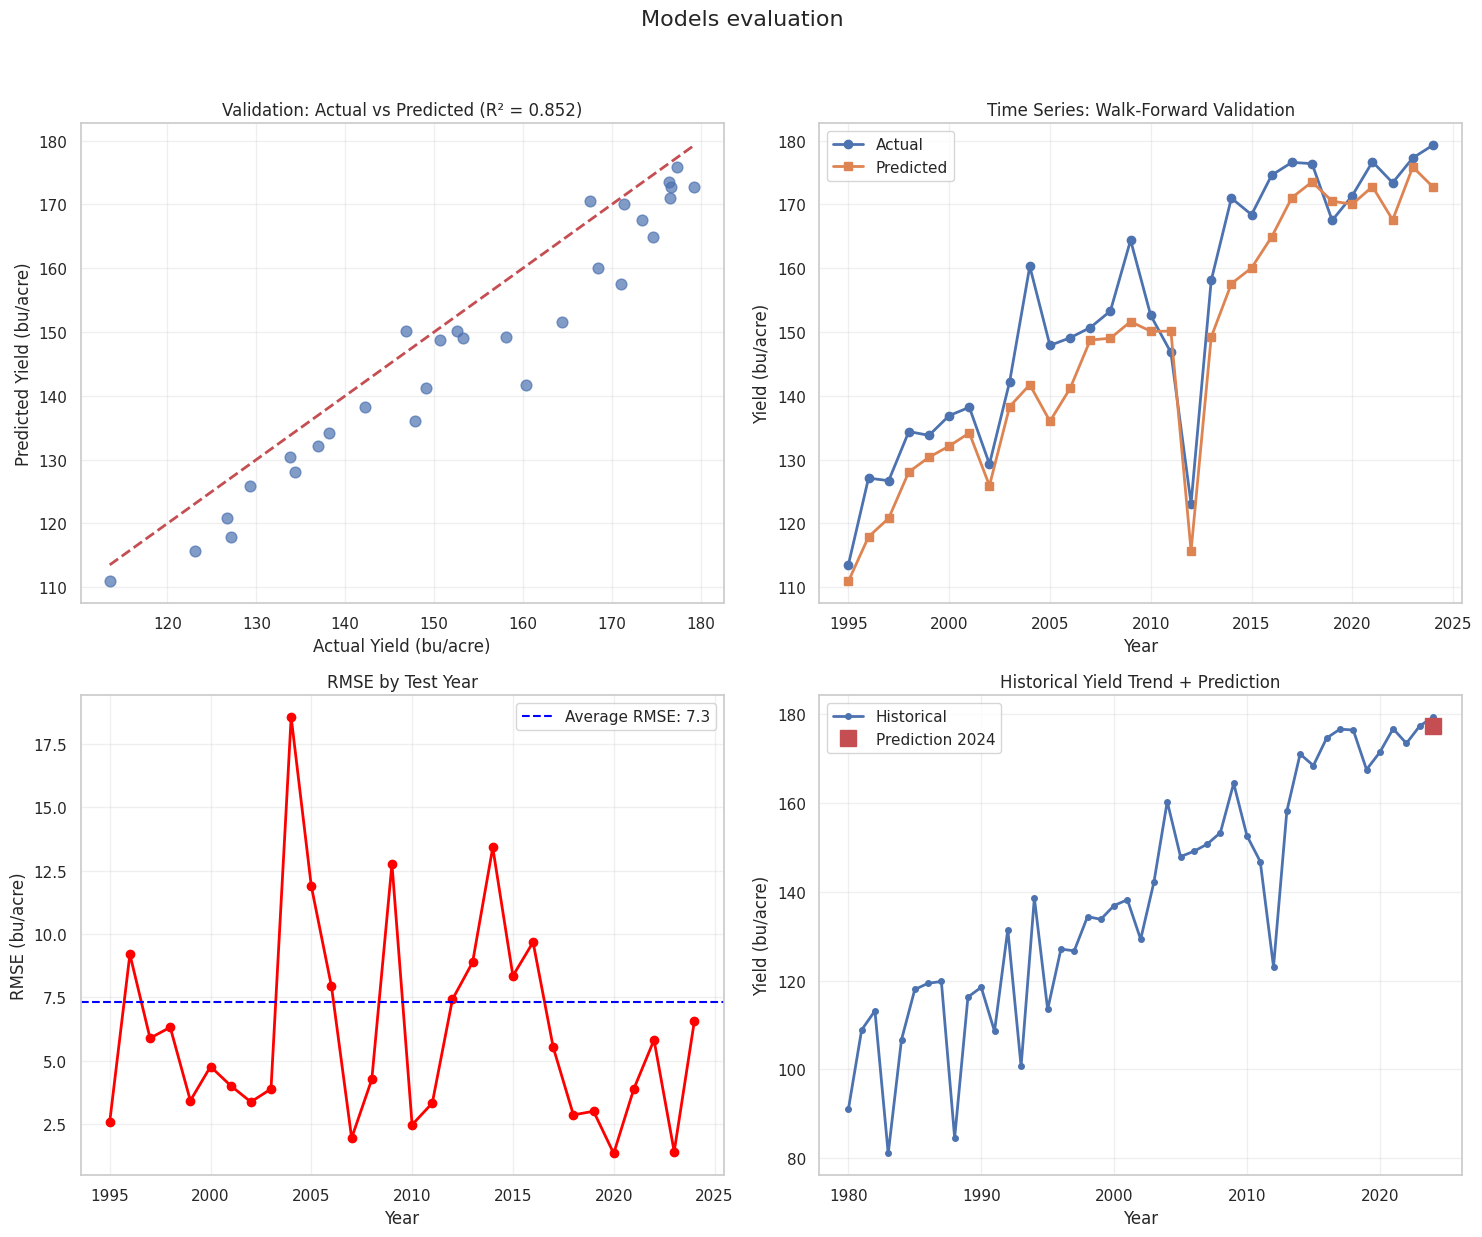

In [25]:
# Visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Models evaluation", fontsize=16, y=1.03)

# 1. Validation: Actual vs Predicted
ax1.scatter(actuals, predictions, alpha=0.7, s=60)
ax1.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
ax1.set_xlabel('Actual Yield (bu/acre)')
ax1.set_ylabel('Predicted Yield (bu/acre)')
ax1.set_title(f'Validation: Actual vs Predicted (R² = {r2_score_val:.3f})')
ax1.grid(True, alpha=0.3)

# 2. Time series: validation
ax2.plot(test_years, actuals, 'o-', label='Actual', linewidth=2, markersize=6)
ax2.plot(test_years, predictions, 's-', label='Predicted', linewidth=2, markersize=6)
ax2.set_xlabel('Year')
ax2.set_ylabel('Yield (bu/acre)')
ax2.set_title('Time Series: Walk-Forward Validation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. RMSE by year
ax3.plot(test_years, rmse_scores, 'o-', linewidth=2, markersize=6, color='red')
ax3.axhline(y=overall_rmse, color='blue', linestyle='--', label=f'Average RMSE: {overall_rmse:.1f}')
ax3.set_xlabel('Year')
ax3.set_ylabel('RMSE (bu/acre)')
ax3.set_title('RMSE by Test Year')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Historical trend + prediction
years_all = model_df['Year']
yields_all = model_df['NATIONAL_yield']
ax4.plot(years_all, yields_all, 'o-', label='Historical', linewidth=2, markersize=4)

if len(last_year_data) > 0:
    ax4.plot(last_year + 1, prediction_next_year, 'rs', markersize=12, label=f'Prediction {last_year + 1}')

ax4.set_xlabel('Year')
ax4.set_ylabel('Yield (bu/acre)')
ax4.set_title('Historical Yield Trend + Prediction')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Final summary
print("=" * 60)
print("XGBOOST MODEL SUMMARY - NATIONAL_yield")
print("=" * 60)
print(f"📊 Data: {model_df.shape[0]} years ({model_df['Year'].min()}–{model_df['Year'].max()})")
print(f"🔧 Features: {len(feature_cols)} (yields + weather + lags)")
print(f"📈 Validation RMSE: {overall_rmse:.2f} bu/acre")
print(f"📈 Validation R²: {r2_score_val:.3f}")
print(f"🎯 Top 3 features: {', '.join(feature_importance.head(3)['feature'].tolist())}")

if len(last_year_data) > 0:
    print(f"🔮 Prediction for {last_year + 1}: {prediction_next_year:.1f} bu/acre")
    print(f"📊 Change vs {last_year}: {prediction_next_year - last_actual:+.1f} bu/acre")

print("=" * 60)


XGBOOST MODEL SUMMARY - NATIONAL_yield
📊 Data: 45 years (1980–2024)
🔧 Features: 110 (yields + weather + lags)
📈 Validation RMSE: 7.34 bu/acre
📈 Validation R²: 0.852
🎯 Top 3 features: IOWA_yield, SOUTH DAKOTA_yield, ILLINOIS_yield
🔮 Prediction for 2024: 177.3 bu/acre
📊 Change vs 2023: -0.0 bu/acre
